import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),  # Added payments.csv for specific handling
    ('order_items.csv','order_items.csv')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='55555das',
    database='pythondaq',
    auth_plugin='mysql_native_password'
)

cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/shind/Downloads/archive'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

In [2]:
db  = mysql.connector.connect(
    host='localhost',
    user='root',
    password='55555das',
    database='pythondaq',
    auth_plugin='mysql_native_password'
)
cur =db.cursor()

In [4]:
#1. List all unique cities where customers are located.
query=""" select distinct customer_city from customers"""
cur.execute(query)
data =cur.fetchall()
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

In [5]:
#2. Count the number of orders placed in 2017.
#query=""" select count(order_id)  from orders where order_purchase_timestamp like '2017%'"""
query=""" select count(order_id)  from orders where year(order_purchase_timestamp)=2017 """
cur.execute(query)
data =cur.fetchall()
data

[(45101,)]

Category         1
Total_Revenue    0
dtype: int64


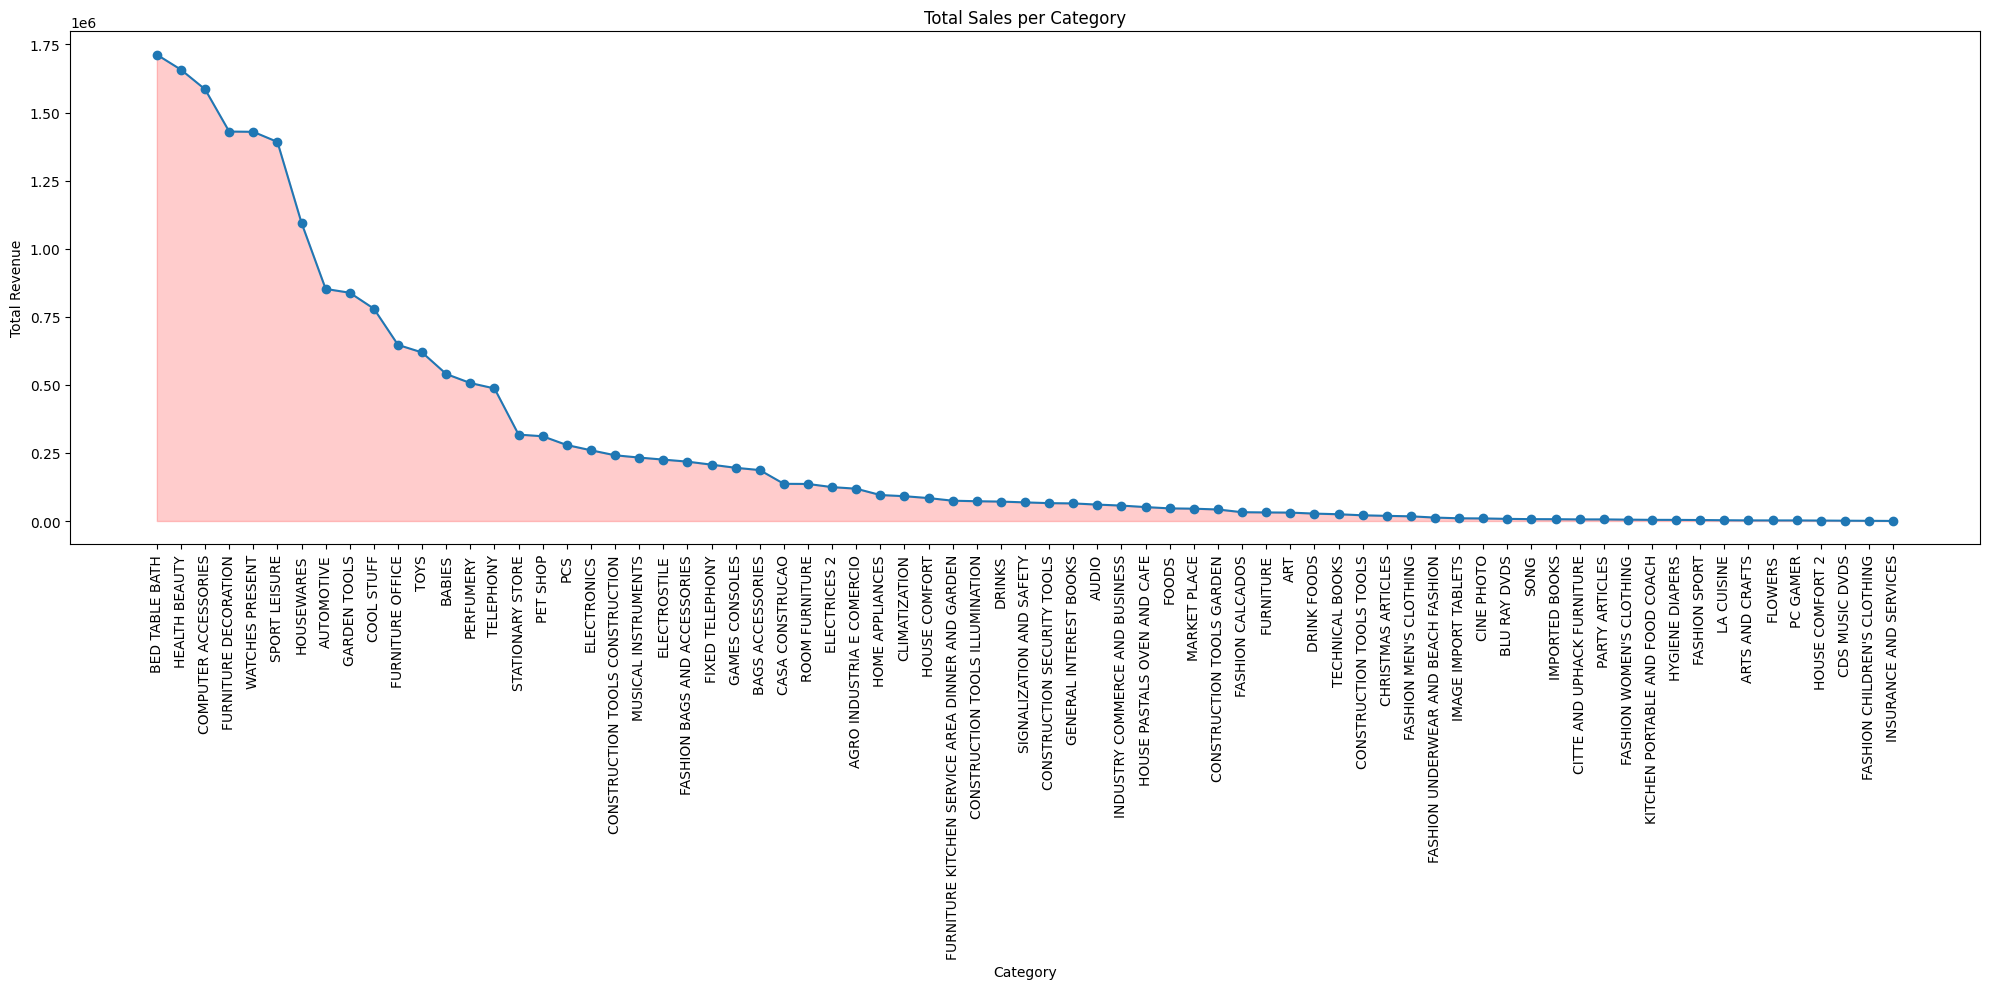

In [6]:
#3. Find the total sales per category.
query=""" select upper(products.product_category) ,round(sum(payments.payment_value))  AS sales from products
join order_items on 
products.product_id=order_items.product_id join payments   on payments.order_id=order_items.order_id
group by products.product_category  order by sales desc """
cur.execute(query)
data =cur.fetchall()

df=pd.DataFrame(data,columns=['Category','Total_Revenue'])
df['Total_Revenue'] = pd.to_numeric(df['Total_Revenue'], errors='coerce')

# Check for any NaN values that may have resulted from conversion
print(df.isnull().sum())

# Drop any rows with NaN values if necessary
df.dropna(inplace=True)

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(df['Category'], df['Total_Revenue'], marker='o')
plt.title('Total Sales per Category')
plt.xlabel('Category')
plt.ylabel('Total Revenue')
plt.fill_between(df['Category'], df['Total_Revenue'], color='red', alpha=0.2)  # Fill with solid color
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [7]:
#4. Calculate the percentage of orders that were paid in installments.

query=""" select (sum(case when payment_installments>1 then 1 else 0 end)/count(payment_installments))*100 from payments   """
cur.execute(query)
data =cur.fetchall()
data[0][0]

Decimal('49.4176')

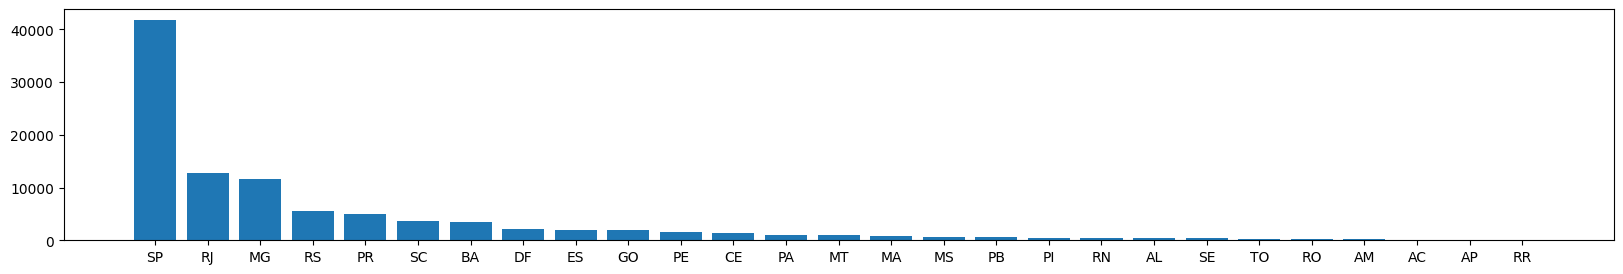

In [8]:
#5. Count the number of customers from each state. 
query=""" select  customer_state, count(customer_state) as count from customers group by customer_state order by count desc"""
cur.execute(query)
data =cur.fetchall()
data 

df=pd.DataFrame(data,columns=['State','Customer_count'])
plt.figure(figsize=(20, 3))
plt.bar(df['State'],df['Customer_count'])  

plt.show()

## Intermidiate Questions


   Months  Sales
0       7   6292
1       8   6512
2       2   6728
3       6   6167
4       3   7211
5       1   7269
6       5   6873
7       4   6939
8       9     16
9      10      4


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'January'),
  Text(1, 0, 'February'),
  Text(2, 0, 'March'),
  Text(3, 0, 'April'),
  Text(4, 0, 'May'),
  Text(5, 0, 'June'),
  Text(6, 0, 'July'),
  Text(7, 0, 'August'),
  Text(8, 0, 'September'),
  Text(9, 0, 'October')])

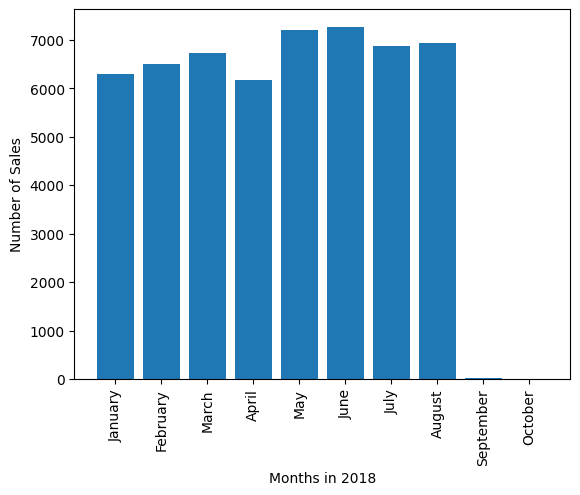

In [9]:
#1. Calculate the number of orders per month in 2018.
query=""" select  month(order_purchase_timestamp) as month, count(order_id) from orders where year(order_purchase_timestamp)=2018 group by month  """
cur.execute(query)
data =cur.fetchall()
#data 
months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October']
df=pd.DataFrame(data ,columns=['Months','Sales'])
print(df)

plt.bar(months,df['Sales'])
plt.xlabel('Months in 2018')
plt.ylabel('Number of Sales')
plt.xticks(rotation=90)

In [10]:
#2. Find the average number of products per order, grouped by customer city.
query=""" with count_per_order as (select  orders.order_id,orders.customer_id  ,count(order_items.order_id) as oc from orders join order_items
on orders.order_id=order_items.order_id group by orders.order_id,orders.customer_id )
select customers.customer_city,round(avg(count_per_order.oc),2) as average_oc from customers join count_per_order 
on customers.customer_id =count_per_order.customer_id group by customers.customer_city order by average_oc desc
"""
cur.execute(query)
data =cur.fetchall()
df=pd.DataFrame(data,columns=['City','AvgOrderCount'])
df

,City,AvgOrderCount
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
...,...,...
4105,sebastiao leal,1.00
4106,morro agudo de goias,1.00
4107,santa filomena,1.00
4108,guamiranga,1.00


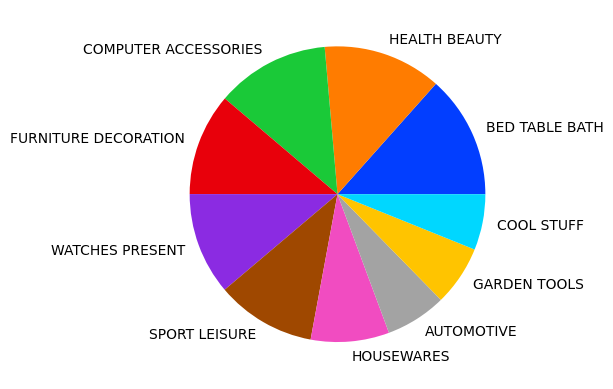

In [36]:
#3. Calculate the percentage of total revenue contributed by each product category.
query = """select upper(products.product_category) as category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) as sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()
#top performing categories pie chart
palette_color = sns.color_palette('bright')
plt.pie(df['percentage distribution'].head(10), labels=df['Category'].head(10), colors=palette_color) 
  
# displaying chart 
plt.show()

In [15]:
#4. Identify the correlation between product price and the number of times a product has been purchased.
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "count",'avg_price'])
#df.head()
print(np.corrcoef(df["count"],df['avg_price']))

[[ 1.         -0.10631514]
 [-0.10631514  1.        ]]


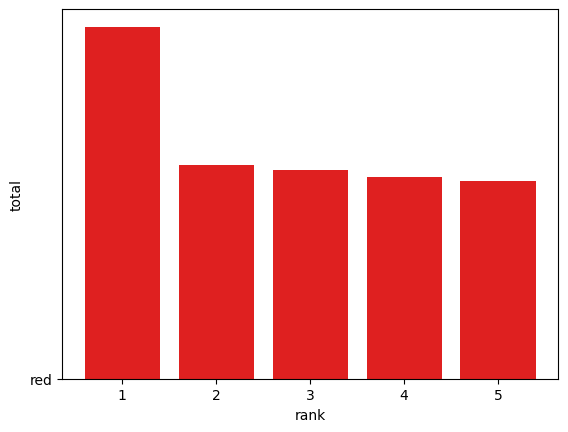

In [28]:
#5. Calculate the total revenue generated by each seller, and rank them by revenue.
query = """select *, dense_rank() over(order by total desc) as rn from
(select order_items.seller_id , round(sum(payments.payment_value)) as total
 from order_items join payments on order_items.order_id=payments.order_id group by seller_id order by total desc) as a"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["seller", "total",'rank'])
df.head()
sns.barplot(x='rank', y='total', data=df.head(),color='red')

# Advanced Queries

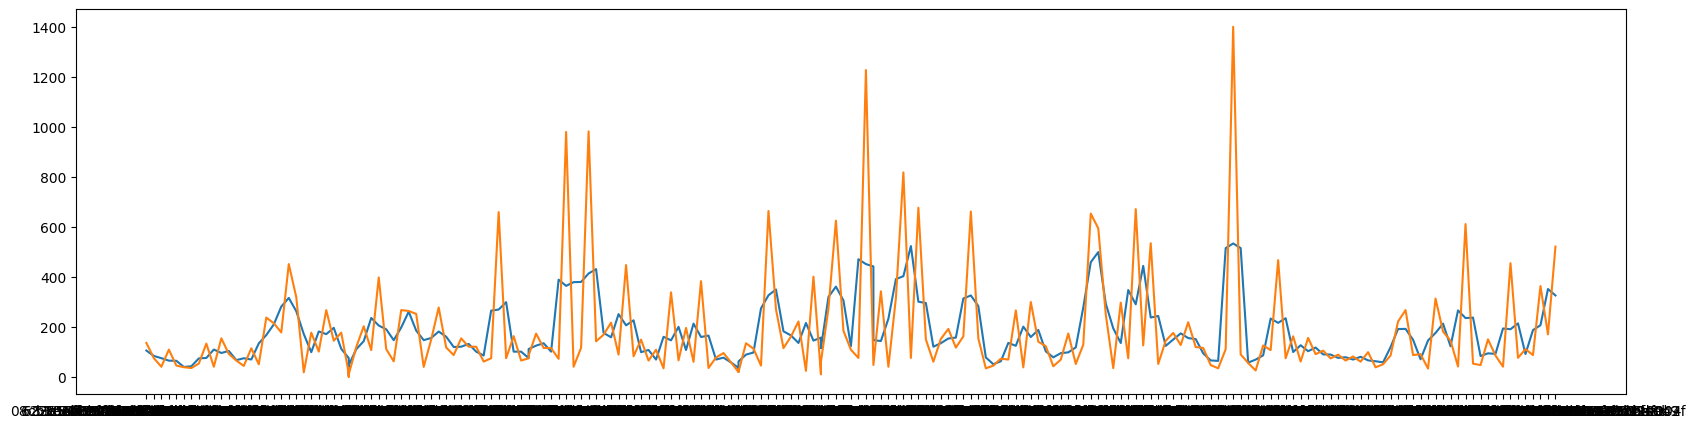

In [39]:
#1. Calculate the moving average of order values for each customer over their order history.
query = """SELECT customer_id, 
       order_purchase_timestamp, 
       payment,
       ROUND(AVG(payment) OVER (
           ORDER BY order_purchase_timestamp 
           ROWS BETWEEN 1 PRECEDING AND 1 FOLLOWING
       ), 2) AS mov_avg
FROM (
    SELECT orders.customer_id, 
           orders.order_purchase_timestamp, 
           payments.payment_value AS payment
    FROM payments 
    JOIN orders ON payments.order_id = orders.order_id
) AS a;
"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer", "time",'price_value','moving average'])
df.head()
plt.figure(figsize=( 20,5))
plt.plot(  df['customer'].head(200), df['moving average'].head(200), label = "line 1")
plt.plot( df['customer'].head(200), df['price_value'].head(200),label = "line 2")

plt.show()

In [42]:
#2 Calculate the cumulative sales per month for each year.
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


<Axes: xlabel='year', ylabel='yoyGrowth'>

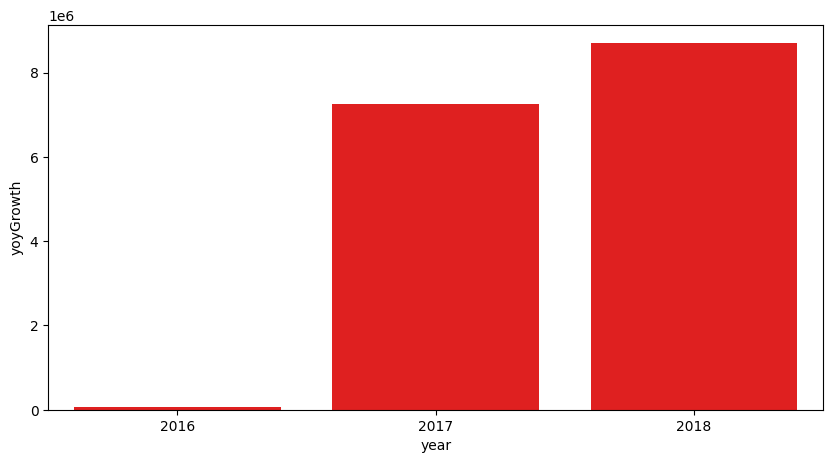

In [61]:
#2 Calculate the cumulative sales per month for each year.
query = """select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['year','yoyGrowth'])
df
plt.figure(figsize=( 10,5))
sns.barplot(x='year', y='yoyGrowth', data=df,color='red')

<Axes: xlabel='year', ylabel='yoyGrowth'>

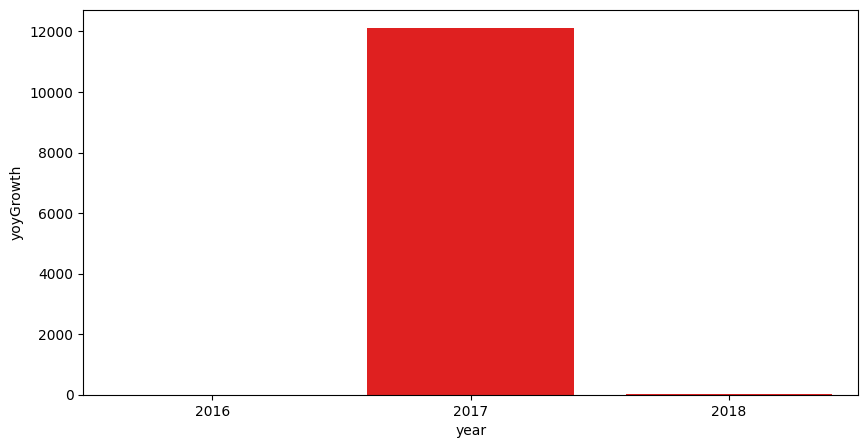

In [62]:
#2 Calculate the cumulative sales per month for each year.
query = """ with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)
select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['year','yoyGrowth'])
df
plt.figure(figsize=( 10,5))
sns.barplot(x='year', y='yoyGrowth', data=df,color='red')

In [63]:
#Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

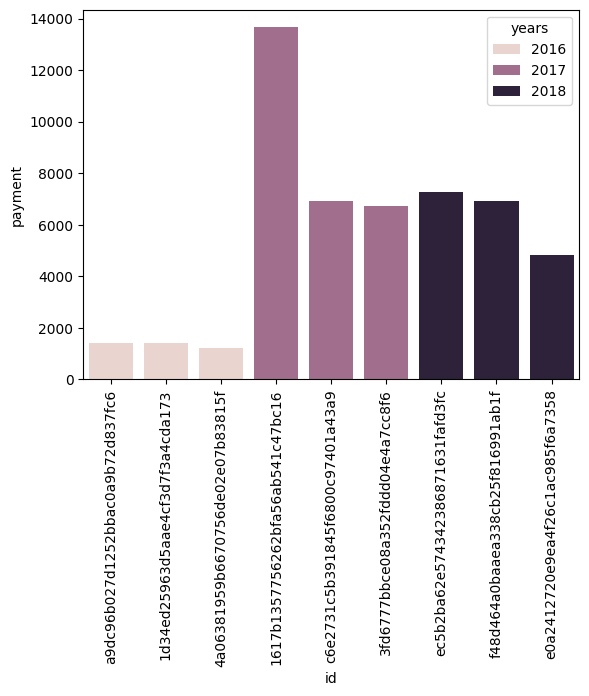

In [65]:
#5. Identify the top 3 customers who spent the most money in each year.
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()